# Preamble

Code to generate the embeddings used in `application_multiomics` to visualize results of the pregnancy multiomics study.

In [1]:
notebook_name = "application_multiomics_prepare-embeddings"
random_state = 42

# Imports

In [2]:
%load_ext autoreload
%autoreload 2

# disable parallelization for BLAS and co.
from corals.threads import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=16)

# general
import re
import collections
import pickle
import warnings 
import joblib
import pathlib
import time

# data
import numpy as np
import pandas as pd
import h5py

# ml / stats
import sklearn
import scipy.stats

# plotting
import matplotlib.pyplot as plt

# init matplotlib defaults
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [3]:
import sklearn.manifold
import sklearn.impute
import sklearn.pipeline

In [ ]:
import coralsarticle.data.applications.multiomics
from coralsarticle.data.utils import preprocess
from corals.correlation.utils import preprocess_X

# Data and functions

In [5]:
data_preg = coralsarticle.data.applications.multiomics.load_pregnancy_multiomics_data()

In [6]:
feature_groups = sorted(coralsarticle.data.applications.multiomics.pregnancy_multiomics_subset_info.keys())

# Calculate and save feature embeddings

In [7]:
feature_groups

['cellfree_rna',
 'immune_system',
 'metabolomics',
 'microbiome',
 'plasma_luminex',
 'plasma_somalogic',
 'serum_luminex']

In [8]:
tnse_perplexity = [
    30, 
    30, 
    30, # metabolomics
    30, # microbiome 
    30, 
    30, 
    30]

embedding___data_pregnancy___preprocessing_neg_n2___cor-spearman-direct___algorithm_tsne_v2___ cellfree_rna
* size before preprocessing: 37275
* size after preprocessing:  36015
* preprocess
* data matrix shape: (68, 36015)
* tsne: 222.97095727920532 seconds
* plot


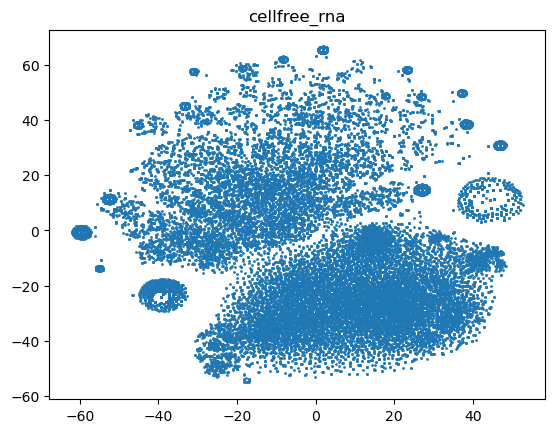

embedding___data_pregnancy___preprocessing_neg_n2___cor-spearman-direct___algorithm_tsne_v2___ immune_system
* size before preprocessing: 534
* size after preprocessing:  528
* preprocess
* data matrix shape: (68, 528)
* tsne: 1.109814167022705 seconds
* plot


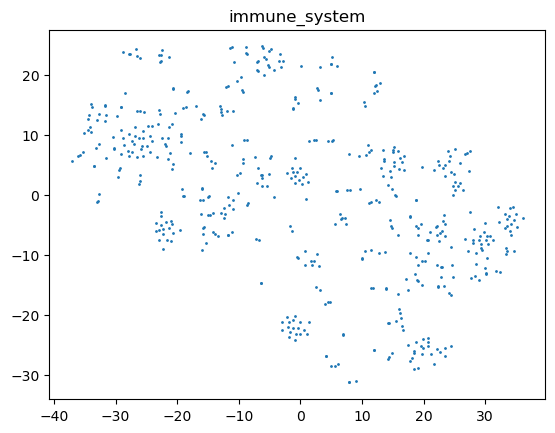

embedding___data_pregnancy___preprocessing_neg_n2___cor-spearman-direct___algorithm_tsne_v2___ metabolomics
* size before preprocessing: 3485
* size after preprocessing:  818
* preprocess
* data matrix shape: (68, 818)
* tsne: 1.8597619533538818 seconds
* plot


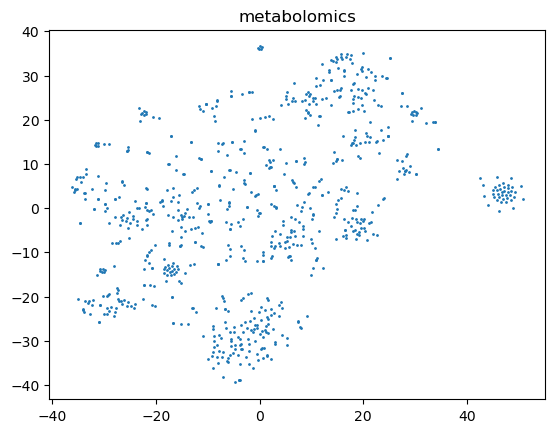

embedding___data_pregnancy___preprocessing_neg_n2___cor-spearman-direct___algorithm_tsne_v2___ microbiome
* size before preprocessing: 18548
* size after preprocessing:  2914
* preprocess
* data matrix shape: (68, 2914)
* tsne: 10.115959405899048 seconds
* plot


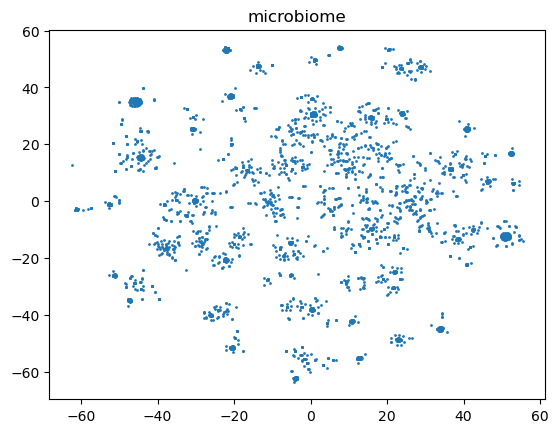

embedding___data_pregnancy___preprocessing_neg_n2___cor-spearman-direct___algorithm_tsne_v2___ plasma_luminex
* size before preprocessing: 62
* size after preprocessing:  62
* preprocess
* data matrix shape: (68, 62)
* tsne: 0.37339186668395996 seconds
* plot


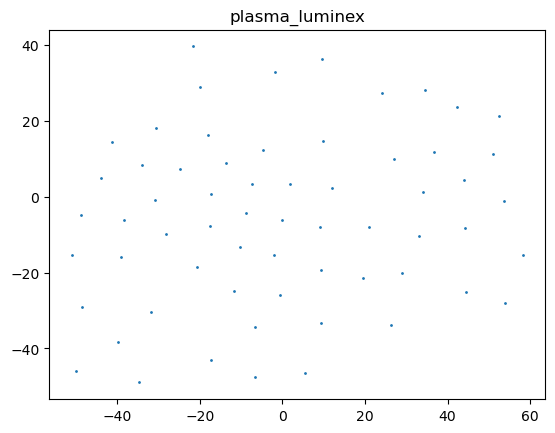

embedding___data_pregnancy___preprocessing_neg_n2___cor-spearman-direct___algorithm_tsne_v2___ plasma_somalogic
* size before preprocessing: 1300
* size after preprocessing:  1300
* preprocess
* data matrix shape: (68, 1300)
* tsne: 3.583817481994629 seconds
* plot


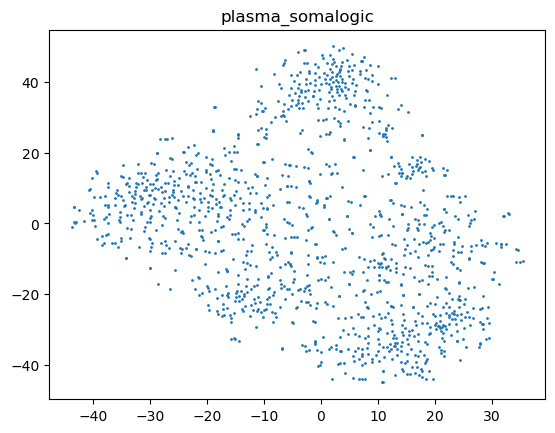

embedding___data_pregnancy___preprocessing_neg_n2___cor-spearman-direct___algorithm_tsne_v2___ serum_luminex
* size before preprocessing: 62
* size after preprocessing:  62
* preprocess
* data matrix shape: (68, 62)
* tsne: 0.24237465858459473 seconds
* plot


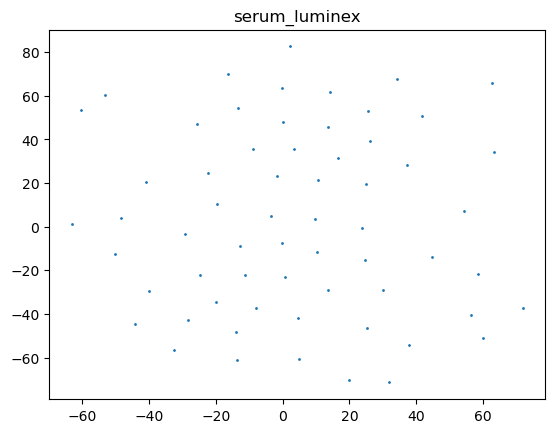

CPU times: user 22min 45s, sys: 54.3 s, total: 23min 39s
Wall time: 4min 9s


In [9]:
%%time
prefix = "embedding___data_pregnancy___preprocessing_neg_n2___cor-spearman-direct___algorithm_tsne_v2___"
path =  pathlib.Path(f"../_out/applications/{notebook_name}")

path.mkdir(parents=True, exist_ok=True)

for i_r, row_group in enumerate(feature_groups):
    
#     if row_group == "cellfree_rna":
#         continue
        
    file_name = f"{prefix}featuregroup_{row_group}"
    
    file_h5 = path / f"{file_name}.h5"
    file_plot = path / f"{file_name}.png"
    if not file_h5.exists():
    
        print(prefix, row_group)

        X = data_preg[row_group].values
        print("* size before preprocessing:", X.shape[1])
        X, msk = preprocess(
            X, return_mask=True, 
            negative=True, drop_duplicates=False, min_nunique=2)
        print("* size after preprocessing: ", X.shape[1])
        
        print("* preprocess")
        
        X = scipy.stats.mstats.rankdata(X, axis=0)
        X = preprocess_X(X)
        print("* data matrix shape:", X.shape)
        
        print("* tsne: ", end="")
        alg = sklearn.manifold.TSNE(n_components=2, perplexity=tnse_perplexity[i_r], random_state=random_state)
        
        time_start = time.time()
        emb = alg.fit_transform(X.transpose())
        time_diff = time.time() - time_start
        print(time_diff, "seconds")
    
        print("* plot")
        plt.figure()
        plt.scatter(emb[:,0], emb[:,1], s=1)
        plt.title(row_group)
        plt.savefig(file_plot)
        plt.show()
        plt.close()
        
#         print("pickle")
#         pickle.dump((emb, msk), open(file, "wb"))
        
        with h5py.File(file_h5, "w") as f:
            f["embedding"] = emb
            f["mask"] = msk
            f["time"] = time_diff